### Extreme Value Distributions

In [4]:
import pymc3 as pm
%matplotlib inline

In [104]:
def plot_extreme_values(dist, ax, n=100, count=10000, bins=50, alpha=1, label=None):
    maxes = [dist.rvs(n).max() for i in range(count)]
    ax.hist(maxes, bins=bins, alpha=alpha, label=label, normed=True)


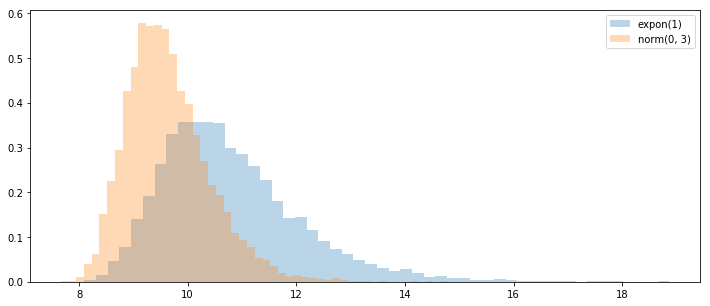

In [60]:
dist1 = scs.expon(1)
dist2 = scs.norm(0, 2.5)

fig, ax = plt.subplots(figsize=(12,5))
plot_extreme_values(dist1, ax, alpha=0.3, label='expon(1)')
plot_extreme_values(dist2, ax, alpha=0.3, label='norm(0, 3)')
plt.legend()

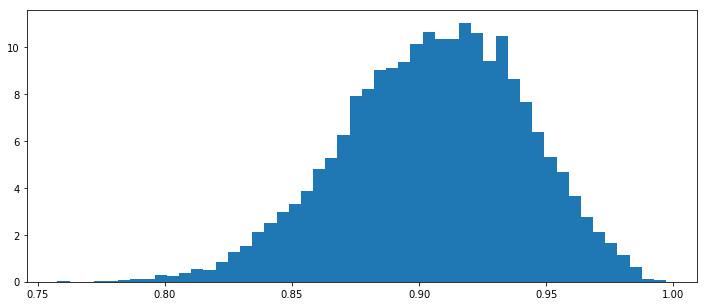

In [107]:
fig, ax = plt.subplots(figsize=(12,5))
plot_extreme_values(scs.beta(3,3), ax)


18.254158285001296

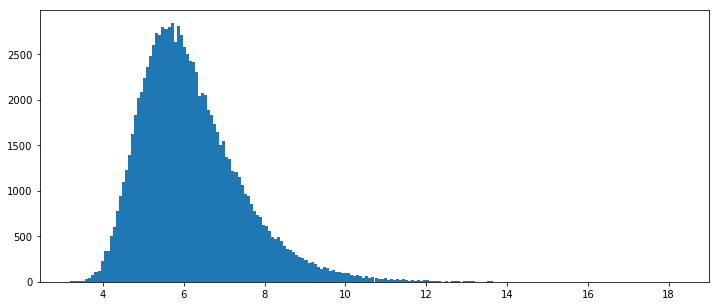

In [33]:
ax.hist(maxes, bins=200)
max(maxes)

In [34]:
dist = scs.norm(0, 1)
maxes = [dist.rvs(100).max() for i in range(100000)]

5.5221489177775522

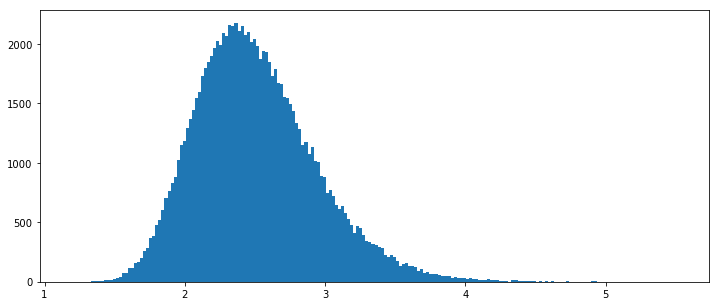

In [35]:
fig, ax = plt.subplots(figsize=(12,5))
ax.hist(maxes, bins=200)
max(maxes)

In [30]:
dist.mean()

0.0

In [98]:
n = 100000
success = 0
for i in range(n):
    a = np.random.random((3, 3))
    a /= a.sum(axis=0)
    if (a.argmax(axis=1) == np.array([0, 2, 2])).all():
        success += 1
success/n

0.02642

In [90]:
a = np.random.random((3, 3))
a /= a.sum(axis=0)
print(a)
a.argmax(axis=1)

[[ 0.19105803  0.10373684  0.06789217]
 [ 0.49711739  0.57082624  0.56896911]
 [ 0.31182458  0.32543692  0.36313872]]


array([0, 1, 2])

In [100]:
.025*18 + .09*6

0.99

# Estimating Extreme-Value Distribution

I think the POT approach is better?

It seems best to do an MLE (or bayesian) weighted fit for a GEVD. Let's try MLE.

Let's sort the original sample and sort (decreasing by size, so we have $x_0$ as the largest,then $x_1$, etc.

Let's choose a sample (without replacement) from the original that's half the original size. The probability that the maximum is $x_0$ is $1 \over 2$, the probability that $x_1$ is the maximum is $1 \over 4$, etc.

So we could to a weighted MLE fit of a GEVF. Or we could do a weighted bayesian analysis, somehow. I'm not sure how.

Note that there's a (hyper-?)parameter, the fractional size of the subsample. I'm not sure of the effect exactly. If it's very small, values below the tail will be included (high bias). If it's very big, it will overweight the largest values (high variance).

*Maybe* it would be correct to do a bootstrap sample instead and remove the hyper-parameter.

In any case, I don't think it's necessary to choose a threshold since the probabilities drop geometrically.

## MLE

Using scipy.stats. First, we'll do an actual fit from a normal distribution, without any fancy bootstrapping.

In [142]:
size_sample = 100
n_samples = 10000
dist = scs.beta(1,0.4)
maxes = []
for i in range(n_samples):
    maxes.append(dist.rvs(size_sample).max())

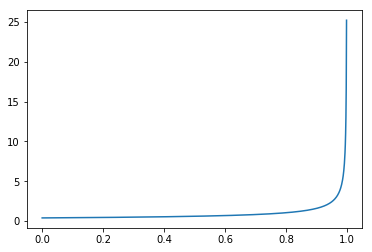

In [143]:
fig, ax = plt.subplots()
xpts = np.linspace(0,1, 1000)
ax.plot(xpts, dist.pdf(xpts))

Fitting the data.

In [144]:
params = scs.genextreme.fit(maxes)
params

(1.4522664791219593, 0.99998472920638326, 2.2177261679019207e-05)

In [146]:
np.min(maxes)

0.99662394244277552

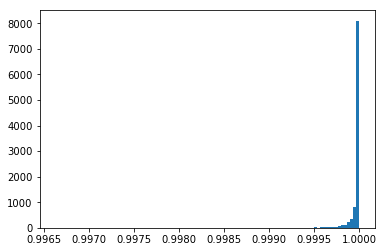

In [153]:
fig, ax = plt.subplots()
_ = ax.hist(maxes, bins=100)
#ax.set_xlim(8, 11)

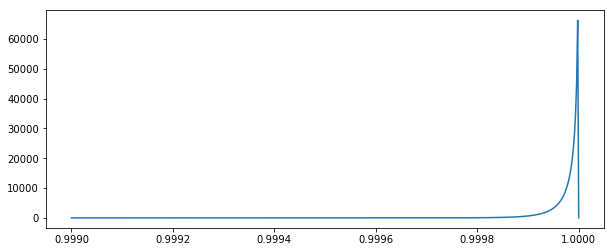

In [152]:
fig, ax = plt.subplots(figsize=(10,4))
xpts = np.linspace(0.999, 1, 500)
mle = scs.genextreme(*params)
ax.plot(xpts, mle.pdf(xpts))

Okay, now the goal is to use the approach described above to solve from a single sample.

Crap. There's no way to specify weights in scipy fit.

Or, I think, with pymc3. Next up: pytorch.

# MLE in pymc3

In [6]:
import pymc3 as pm
%matplotlib inline

In [13]:
def weight_data(data, count=10, p=0.5):
    sorted_data = sorted(data, reverse=True)
    result = []
    for i in range(count):
        result = result * 2
        result.append(sorted_data[i])
    return result

In [15]:
data = scs.uniform(0,1).rvs(1000)
weighted_data = weight_data(data, 10)

In [16]:
with pm.Model() as model:
    alpha = pm.Uniform(name='alpha', lower=0, upper=100)
    beta = pm.Uniform(name='beta', lower=0, upper=100)
    observered = pm.Weibull(name='observed', alpha=alpha, beta=beta, observed=weighted_data)

In [17]:
with model:
    trace = pm.sample(10000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|█████████▉| 10477/10500 [00:43<00:00, 242.76it/s]/Users/jackbennetto/anaconda/envs/py36/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:451: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.946163419006, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
100%|██████████| 10500/10500 [00:43<00:00, 242.66it/s]


array([<matplotlib.axes._subplots.AxesSubplot object at 0x1169194e0>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x117023940>], dtype=object)

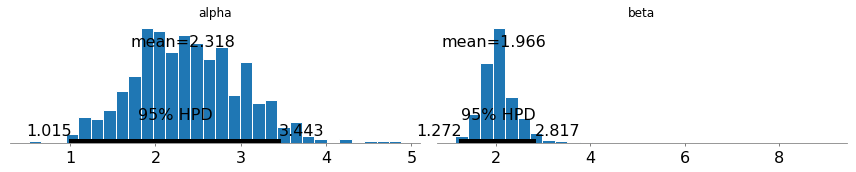

In [7]:
pm.plot_posterior(trace)

I don't think that's correct, that instead we need weighted numbers with a weighting of less than one.

## Experimentation with fitting

First, let's draw some graphs of weibull distributions.

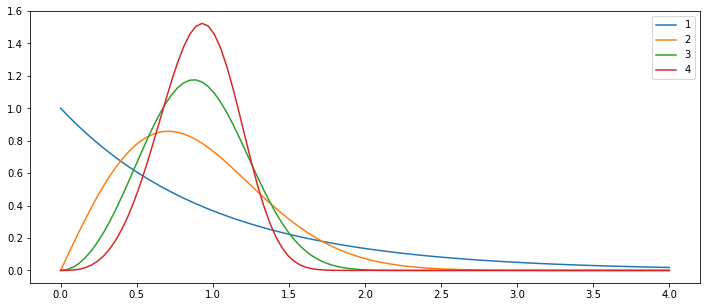

In [16]:
fig, ax = plt.subplots(figsize=(12, 5))

xpts = np.linspace(0, 4, 100)
for c in range(1,5):
    ax.plot(xpts, scs.weibull_min(c).pdf(xpts), label=str(c))
plt.legend()

In [24]:
population = scs.beta(2,2)
mins = []
for i in range(10000):
    sample_min = population.rvs(100).min()
    mins.append(sample_min)
params = scs.weibull_min.fit(mins)

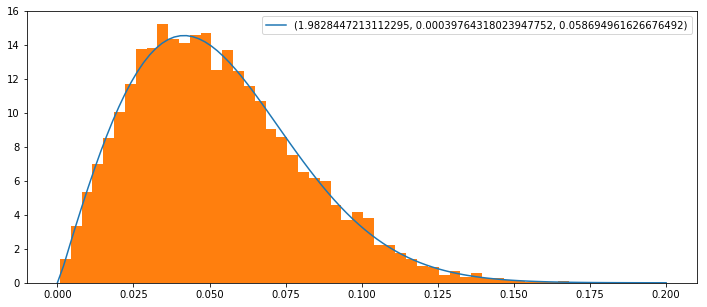

In [26]:
fig, ax = plt.subplots(figsize=(12, 5))

xpts = np.linspace(0, 0.2, 100)
ax.plot(xpts, scs.weibull_min(*params).pdf(xpts), label=str(params))
ax.hist(mins, normed=True, bins=50)
plt.legend()

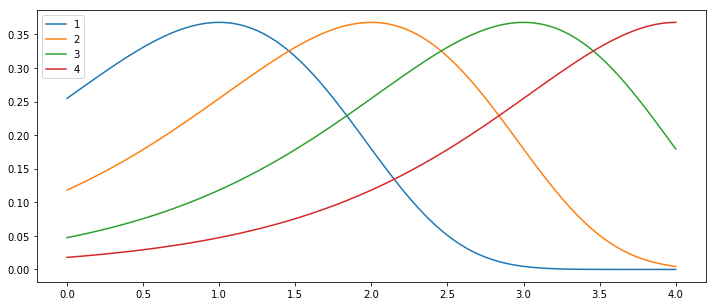

In [27]:
fig, ax = plt.subplots(figsize=(12, 5))

xpts = np.linspace(0, 4, 100)
for c in range(1,5):
    ax.plot(xpts, scs.gumbel_l(c).pdf(xpts), label=str(c))
plt.legend()

In [62]:
population = scs.norm(0, 1)
maxes = []
for i in range(10000):
    sample_max = population.rvs(1000).max()
    maxes.append(sample_max)
params = scs.gumbel_r.fit(maxes)

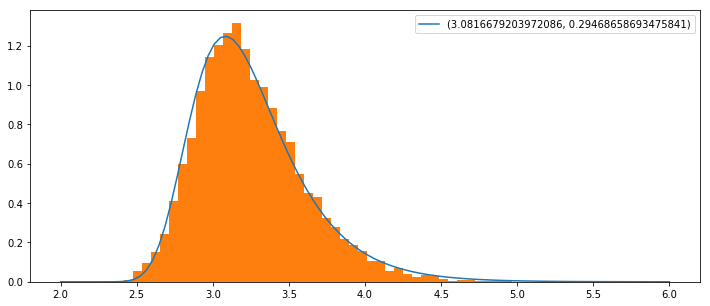

In [64]:
fig, ax = plt.subplots(figsize=(12, 5))

xpts = np.linspace(2, 6, 100)
ax.plot(xpts, scs.gumbel_r(*params).pdf(xpts), label=str(params))
ax.hist(maxes, normed=True, bins=50)
plt.legend()

## Doing bayes correctly

I think to do bayes correctly we need to do weighting with paired observations.

### Paired observations

First, let's make sure we understand paired observations

In [83]:
data = [1, 0, 2, 0, 2, 1, 3, 1]
with pm.Model() as model:
    
    mu = pm.Uniform(name='mu', lower=-10, upper=10)
    sd = pm.Uniform(name='sd', lower=0, upper=10)
    observered = pm.Normal(name='observed', mu=mu, sd=sd, observed=data)

In [84]:
with model:
    trace = pm.sample(10000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|█████████▉| 10475/10500 [00:18<00:00, 570.48it/s]/Users/jackbennetto/anaconda/envs/py36/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:451: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.881683658792, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
100%|██████████| 10500/10500 [00:18<00:00, 569.53it/s]


array([<matplotlib.axes._subplots.AxesSubplot object at 0x10f239da0>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x10f50a438>], dtype=object)

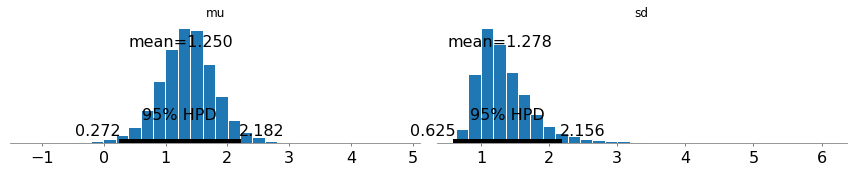

In [85]:
pm.plot_posterior(trace)

In [ ]:
data = scs.uniform(0,1).rvs(1000)


In [ ]:
with pm.Model() as model:
    alpha = pm.Uniform(name='alpha', lower=0, upper=100)
    beta = pm.Uniform(name='beta', lower=0, upper=100)
    observered = pm.Weibull(name='observed', alpha=alpha, beta=beta, observed=weighted_data)